In [1]:
# Data
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Prepprc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection

# pipline
from sklearn.pipeline import make_pipeline, FeatureUnion

# ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#Metrics

from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc


In [38]:
df = pd.read_pickle('../data/clean_pass_01p1.pkl')

In [39]:
x_col = ['addr_state',
'annual_inc',
'dti',
'emp_length',
'home_ownership',
'int_rate',
'loan_amnt',
'open_acc',
'pub_rec',
'pub_rec_bankruptcies',
'purpose',
'term',
'verification_status']
y_col = ['target']


# redue pass 1
# 'emp_title', revist ... advanced feature engineering


In [40]:
df_x = df[x_col]
df_y = df[y_col]

In [41]:
df_x.pub_rec_bankruptcies = df_x.pub_rec_bankruptcies.astype('uint8') 
df_x.select_dtypes('uint8').info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41340 entries, 0 to 42474
Data columns (total 1 columns):
pub_rec_bankruptcies    41340 non-null uint8
dtypes: uint8(1)
memory usage: 363.3 KB


/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Feature importnace try with dummy to recall names


In [42]:
df_x_encoded = pd.get_dummies(df_x, drop_first=True)
for i in df_x_encoded.columns:
    print(i)


annual_inc
dti
emp_length
int_rate
loan_amnt
open_acc
pub_rec
pub_rec_bankruptcies
addr_state_AL
addr_state_AR
addr_state_AZ
addr_state_CA
addr_state_CO
addr_state_CT
addr_state_DC
addr_state_DE
addr_state_FL
addr_state_GA
addr_state_HI
addr_state_IA
addr_state_ID
addr_state_IL
addr_state_IN
addr_state_KS
addr_state_KY
addr_state_LA
addr_state_MA
addr_state_MD
addr_state_ME
addr_state_MI
addr_state_MN
addr_state_MO
addr_state_MS
addr_state_MT
addr_state_NC
addr_state_NE
addr_state_NH
addr_state_NJ
addr_state_NM
addr_state_NV
addr_state_NY
addr_state_OH
addr_state_OK
addr_state_OR
addr_state_PA
addr_state_RI
addr_state_SC
addr_state_SD
addr_state_TN
addr_state_TX
addr_state_UT
addr_state_VA
addr_state_VT
addr_state_WA
addr_state_WI
addr_state_WV
addr_state_WY
home_ownership_OTHER
home_ownership_OWN
home_ownership_RENT
purpose_credit_card
purpose_debt_consolidation
purpose_educational
purpose_home_improvement
purpose_house
purpose_major_purchase
purpose_medical
purpose_moving
purpose_oth

In [43]:
df_x_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41340 entries, 0 to 42474
Data columns (total 74 columns):
annual_inc                    41340 non-null float64
dti                           41340 non-null float64
emp_length                    41340 non-null float64
int_rate                      41340 non-null float64
loan_amnt                     41340 non-null float64
open_acc                      41340 non-null float64
pub_rec                       41340 non-null float64
pub_rec_bankruptcies          41340 non-null uint8
addr_state_AL                 41340 non-null uint8
addr_state_AR                 41340 non-null uint8
addr_state_AZ                 41340 non-null uint8
addr_state_CA                 41340 non-null uint8
addr_state_CO                 41340 non-null uint8
addr_state_CT                 41340 non-null uint8
addr_state_DC                 41340 non-null uint8
addr_state_DE                 41340 non-null uint8
addr_state_FL                 41340 non-null uint8
addr_state

In [44]:
df_x_encoded.addr_state_WY.value_counts()

0    41257
1       83
Name: addr_state_WY, dtype: int64

## create pipline parts for DF use

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)
            
 

In [26]:
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=df_x_encoded.columns),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector('float64'),
            StandardScaler()
        )),
        ("bool_features", make_pipeline(
            TypeSelector('uint8'),
        )),
        #("categorical_features", make_pipeline(
        #    TypeSelector("category"),
        #    OneHotEncoder()
        #)),
    ]))

In [46]:
preprocess_pipeline.fit(df_x_encoded)
X_transformed = preprocess_pipeline.transform(df_x_encoded)    
print(X_transformed.shape)
print(df_x_encoded.shape)
df_y.shape
df_y.values

(41340, 74)
(41340, 74)


array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [51]:
# Using Random Forest to gain an insight on Feature Importance
#clf = DecisionTreeClassifier()
clf = RandomForestClassifier()
clf.fit(X_transformed, df_y)
importance = clf.feature_importances_


/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


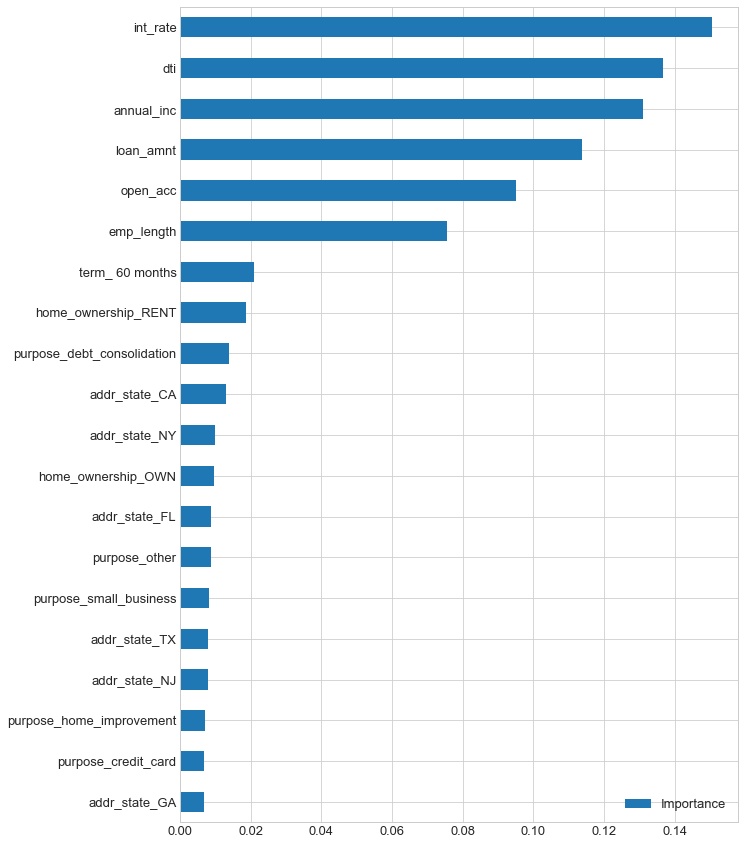

In [54]:
plt.style.use('seaborn-whitegrid')
importance = pd.DataFrame(importance, index=df_x_encoded.columns, columns=["Importance"])
importance = importance.sort_values(['Importance'], ascending=True)
plt.rc('font', size=13)
importance.tail(n=20).plot(kind='barh', figsize=(10,15));

In [ ]:
## TODO merge the dummys to one importnace ... 